In [135]:
import math
import os
import re
from typing import List, Tuple

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from tqdm.notebook import tqdm


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],
            'size':10})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)


In [134]:
df = pd.read_csv("../data/df_ucr_min_delta.csv")

In [136]:
df.sort_values(['ts_1','no_1','min_kpi', 'value'], inplace=True)

In [137]:
df.shape

(30000, 10)

In [138]:
df.head()

,ts_1,no_1,class_1,ts_2,no_2,class_2,type,match_score,min_kpi,value
0,ACSF1,0,9,ACSF1,0,0,Hamming,11111,d_m,0.000000
8,ACSF1,0,9,ACSF1,0,0,Welch,11111,d_m,0.000000
16,ACSF1,0,9,ACSF1,3,3,fft,11111,d_m,0.000000
15,ACSF1,0,9,ACSF1,9,9,Welch,11111,d_max,0.000233
7,ACSF1,0,9,ACSF1,35,35,Hamming,11111,d_max,0.000793


In [139]:
df_verify = df.groupby(['ts_1','no_1','min_kpi']).count()
df_verify[df_verify['value'].isin([1,2])].groupby(['ts_1','no_1']).count().reset_index()
#df_missing[['ts_1','no_1']].to_csv("../data/missing_windows.csv", index=False)

,ts_1,no_1,class_1,ts_2,no_2,class_2,type,match_score,value
0,AllGestureWiimoteX,111,8,8,8,8,8,8,8
1,CinCECGTorso,707,8,8,8,8,8,8,8
2,CinCECGTorso,1277,8,8,8,8,8,8,8
3,CricketY,223,8,8,8,8,8,8,8
4,DodgerLoopDay,34,8,8,8,8,8,8,8
5,DodgerLoopGame,47,8,8,8,8,8,8,8
6,DodgerLoopWeekend,70,8,8,8,8,8,8,8
7,Earthquakes,30,8,8,8,8,8,8,8
8,Earthquakes,67,8,8,8,8,8,8,8
9,Earthquakes,107,8,8,8,8,8,8,8


In [140]:
df[(df['ts_1']=='CinCECGTorso') & (df['no_1']==910)]['type'].unique()

array(['fft', 'Hamming', 'Welch'], dtype=object)

In [141]:
def find_min_kpi(df: pd.DataFrame) -> str:
    """ find min kpi for combination """
    values = list(df['value'])
    idx = []
    for i in range(len(values)):
        if i == 0:
            idx.append(i)
        elif values[i] == idx[i-1]: ## conseqcutive element matches
            idx.append(i)
        else:
            break
            
    df_res = df.iloc[idx,:].sort_values('match_score', ascending=False)
    return df_res.iloc[0,:]
        

In [142]:
df_min = df.groupby(['ts_1','no_1','min_kpi']).apply(find_min_kpi)

In [143]:
df.shape

(30000, 10)

In [148]:
df_min.sort_values('match_score')

ts_1  no_1  class_1  \
ts_1              no_1 min_kpi                                     
ShapeletSim       179  d_max          ShapeletSim   179        1   
                  91   d_m            ShapeletSim    91        1   
                  59   d_std          ShapeletSim    59        0   
                       d_q75          ShapeletSim    59        0   
                       d_q50          ShapeletSim    59        0   
...                                           ...   ...      ...   
FreezerSmallTrain 576  d_m      FreezerSmallTrain   576        1   
                       d_max    FreezerSmallTrain   576        1   
                       d_mean   FreezerSmallTrain   576        1   
                       d_q25    FreezerSmallTrain   576        1   
Yoga              2690 d_std                 Yoga  2690        2   

                                                ts_2  no_2  class_2     type  \
ts_1              no_1 min_kpi                                                 
ShapeletSim       179  d_max                   FordA   101      101      fft   
                  91   d_m           ElectricDevices  4657     4657      fft   
                  59   d_std                   FordB  2558     2558  Hamming   
                       d_q75                   FordB  2011     2011  Hamming   
                       d_q50                   FordA  3462     3462  Hamming   
...                                              ...   ...      ...      ...   
FreezerSmallTrain 576  d_m       FreezerRegularTrain     0        0  Hamming   
                       d_max    UWaveGestureLibraryY   550      550    Welch   
                       d_mean    FreezerRegularTrain   120      120  Hamming   
                       d_q25     FreezerRegularTrain   109      109  Hamming   
Yoga              2690 d_std                    Yoga   251      251    Welch   

                                match_score min_kpi         value  
ts_1              no_1 min_kpi                                     
ShapeletSim       179  d_max          11001   d_max  1.010645e+00  
                  91   d_m            11001     d_m  4.040000e+02  
                  59   d_std          11001   d_std  1.492189e-10  
                       d_q75          11001   d_q75  1.214702e-02  
                       d_q50          11001   d_q50  2.331363e-02  
...                                     ...     ...           ...  
FreezerSmallTrain 576  d_m            11111     d_m  0.000000e+00  
                       d_max          11111   d_max  3.136300e-03  
                       d_mean         11111  d_mean  1.180304e-17  
                       d_q25          11111   d_q25  3.909700e-04  
Yoga              2690 d_std          11111   d_std  3.033500e-10  

[10176 rows x 10 columns]

### Distribution of Match Score

In [87]:
df_fft = df_min[df_min['type']=='fft']
df_ham = df_min[df_min['type']=='Hamming']
df_welch = df_min[df_min['type']=='Welch']

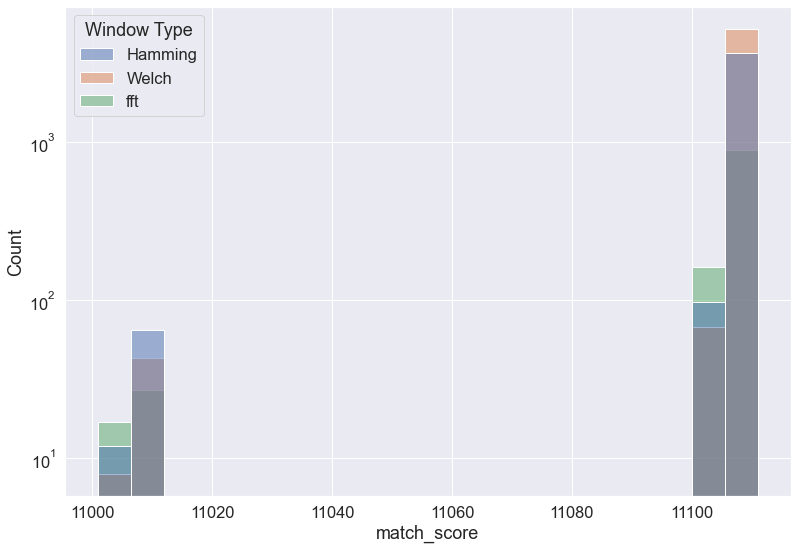

In [147]:
sns.set(font_scale=1.5)
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(13,9))

sns.histplot(df_min, x='match_score', bins=20, hue='type', ax=ax)
leg = ax.get_legend()
leg.set_title("Window Type")
ax.set_yscale('log')
fig.savefig("../img/match_score_dist.png")

In [146]:
df_low = df_min.sort_values('match_score')
df_low.head(20)

ts_1  no_1  class_1             ts_2  no_2  \
ts_1        no_1 min_kpi                                                      
ShapeletSim 179  d_max    ShapeletSim   179        1            FordA   101   
            91   d_m      ShapeletSim    91        1  ElectricDevices  4657   
            59   d_std    ShapeletSim    59        0            FordB  2558   
                 d_q75    ShapeletSim    59        0            FordB  2011   
                 d_q50    ShapeletSim    59        0            FordA  3462   
                 d_q25    ShapeletSim    59        0            FordA  3462   
                 d_min    ShapeletSim    59        0            FordB  2011   
                 d_mean   ShapeletSim    59        0            FordB  2011   
                 d_m      ShapeletSim    59        0            FordA   549   
Earthquakes 69   d_q50    Earthquakes    69        0          FaceAll   518   
                 d_q25    Earthquakes    69        0          FaceAll    93   
                 d_min    Earthquakes    69        0             Crop  6647   
                 d_mean   Earthquakes    69        0          FaceAll   518   
ShapeletSim 91   d_max    ShapeletSim    91        1  ElectricDevices  4657   
Symbols     461  d_q75        Symbols   461        3          Symbols     5   
Earthquakes 67   d_q75    Earthquakes    67        0      Earthquakes    36   
                 d_q50    Earthquakes    67        0      Earthquakes    36   
                 d_q25    Earthquakes    67        0      Earthquakes    36   
                 d_min    Earthquakes    67        0      Earthquakes    36   
                 d_mean   Earthquakes    67        0      Earthquakes    36   

                          class_2     type  match_score min_kpi         value  
ts_1        no_1 min_kpi                                                       
ShapeletSim 179  d_max        101      fft        11001   d_max  1.010645e+00  
            91   d_m         4657      fft        11001     d_m  4.040000e+02  
            59   d_std       2558  Hamming        11001   d_std  1.492189e-10  
                 d_q75       2011  Hamming        11001   d_q75  1.214702e-02  
                 d_q50       3462  Hamming        11001   d_q50  2.331363e-02  
                 d_q25       3462  Hamming        11001   d_q25  5.987086e-02  
                 d_min       2011  Hamming        11001   d_min  6.112663e-01  
                 d_mean      2011  Hamming        11001  d_mean  7.532000e-10  
                 d_m          549  Hamming        11001     d_m  0.000000e+00  
Earthquakes 69   d_q50        518  Hamming        11001   d_q50  1.459270e-01  
                 d_q25         93  Hamming        11001   d_q25  6.397408e-02  
                 d_min       6647      fft        11001   d_min  7.088709e-02  
                 d_mean       518  Hamming        11001  d_mean  8.068974e-11  
ShapeletSim 91   d_max       4657      fft        11001   d_max  1.513785e+00  
Symbols     461  d_q75          5      fft        11001   d_q75  1.423574e-01  
Earthquakes 67   d_q75         36    Welch        11001   d_q75  1.390652e-01  
                 d_q50         36    Welch        11001   d_q50  1.390652e-01  
                 d_q25         36    Welch        11001   d_q25  1.390652e-01  
                 d_min         36    Welch        11001   d_min  1.390652e-01  
                 d_mean        36    Welch        11001  d_mean  5.273437e-09

In [128]:
ts_train_infos = []
ts_test_infos = []
for root, dirs, files in os.walk("../data/ucr_data/UCRArchive_2018/"):
    for name in files:
        if(name.endswith("_TRAIN.tsv")):
            path_tmp = os.path.join(root,name)
            ts_name = re.split("/", root)[-1]
            ts_train_infos.append((ts_name, os.path.join(root,name)))
        elif(name.endswith("_TEST.tsv")):
            path_tmp = os.path.join(root,name)
            ts_name = re.split("/", root)[-1]
            ts_test_infos.append((ts_name, os.path.join(root,name)))
            

In [129]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

for ts_info in tqdm(ts_train_infos):
    ts_name = ts_info[0]
    fp = ts_info[1]
    
    df_tmp = pd.read_csv(fp, sep='\t', header=None)
    df_tmp['name'] = ts_name
    df_tmp['no'] = df_tmp.index
    cols = df_tmp.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df_tmp = df_tmp[cols]
    df_train = df_train.append(df_tmp)
    
for ts_info in tqdm(ts_test_infos):
    ts_name = ts_info[0]
    fp = ts_info[1]
    
    df_tmp = pd.read_csv(fp, sep='\t', header=None)
    df_tmp['name'] = ts_name
    df_tmp['no'] = df_tmp.index
    cols = df_tmp.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df_tmp = df_tmp[cols]
    df_test = df_test.append(df_tmp)
    
# df_train = df_train.reset_index().rename(columns={'index': 'no'})
# df_test = df_test.reset_index().rename(columns={'index': 'no'})
print("df_train shape: {}".format(df_train.shape))
print("df_test shape: {}".format(df_test.shape))

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

df_train shape: (64306, 2847)
df_test shape: (136855, 2847)


In [92]:
df_dtw = pd.read_csv("../data/df_dtw_comp.csv")

In [130]:
def get_dtw_match(ts_name: str,
                  ts_no: int) -> Tuple[str, int,np.ndarray]:
    """ return matching series via DTW """
    print(f"ts: {ts_name}, {ts_no}")
    s_tmp = df_dtw[(df_dtw['ts_1']==ts_name)&
           (df_dtw['no_1']==ts_no)].squeeze()
    print(s_tmp)
    
    ar = np.array(df_train[(df_train['name']==s_tmp['ts_2'])&
             (df_train['no']==s_tmp['no_2'])].iloc[:1,3:].dropna(axis=1))[0]
    return s_tmp['ts_2'], s_tmp['no_2'], ar

In [131]:
def random_results_comparison()->None:
    #sample_idx = df_matches.set_index(['ts_1','no_1']).sample().index[0]
#     ts_name = sample_idx[0]
#     ts_no = sample_idx[1]
    ts_name = 'InsectEPGSmallTrain'
    ts_no = 226


    df_tmp = df[(df['ts_1']==ts_name) &
              (df['no_1']==ts_no)]

    kpis = list(df_tmp['min_kpi'].unique())

    ar_tmpl = np.array(df_test[(df_test['name']==ts_name) &
                          (df_test['no']==ts_no)].iloc[:,3:].dropna(axis=1))[0]

    dtw_name, dtw_no, dtw_ar = get_dtw_match(ts_name, ts_no)


    fig, axs = plt.subplots(4,2, figsize=(15,10))
    fig.tight_layout()

    # plots
    for i in range(8):
        axs.flatten()[i].plot(ar_tmpl, label="Templ: {} - {}".format(ts_name, ts_no))
        axs.flatten()[i].plot(dtw_ar, label="DTW: {} - {}".format(dtw_name, dtw_no))
        kpi = kpis[i] 
        axs.flatten()[i].set_title("{} - match".format(kpi))

        # get winner for particular KPI

        df_min = df_tmp[(df_tmp['ts_1']==ts_name) &
                (df_tmp['no_1']==ts_no) &
                (df_tmp['min_kpi']==kpi)]\
        .sort_values(['match_score','value'], ascending=[False,True])
        # take first entry as it is the lowest

        s_min = df_min.iloc[0,:].squeeze()
        name_tmp = s_min['ts_2']
        no_tmp = s_min['no_2']
        f_type = s_min['type']

        ar_min = np.array(df_train[(df_train['name']==name_tmp)&
           (df_train['no']==no_tmp)].iloc[:,3:].dropna(axis=1))[0]

        axs.flatten()[i].plot(ar_min, label="{}: {} - {}".format(f_type, name_tmp, no_tmp))
        axs.flatten()[i].legend()


    fig.savefig("../img/dtw_fft_comp/{}_{}_ucr_dtw_fft_comp.png".format(ts_name,ts_no))

In [ ]:
random_results_comparison()

In [ ]:
df_train.head()

In [ ]:
ts_name = 'InsectEPGSmallTrain'
ts_no = 226

In [ ]:
s = df_test[(df_test['name']==ts_name)&
                 (df_test['no']==ts_no)].squeeze()
type(s)           

In [132]:
def get_top_k_freq(PSD: np.array, k: int)->List[int]:
    """ return top k indexes with largest PSD val"""
    PSD = [np.real(val) for val in PSD]
    return sorted(range(len(PSD)), key= lambda x: PSD[x])[-k:]


def get_freq_ucr(s: pd.Series, k:int=5) -> List[float]:
    """ compute frequencies for UCR pandas series"""
    fr_dict = dict()
    
    df = pd.DataFrame()
    f=np.array(s.iloc[3:].dropna())
    n = f.shape[0]
    wdw = np.hamming(n)
    freq = np.arange(n)/n

    # FFT
    fhat = np.fft.fft(f)
    PSD = np.real(fhat * np.conj(fhat) / n)
    top_fft_idx = get_top_k_freq(PSD,k)
    fft_freq = freq[top_fft_idx]
    df_tmp = pd.DataFrame(fft_freq, columns=['val'])
    df_tmp['type']='FFT'
    df = df.append(df_tmp)
    fr_dict.update({"fft":(freq,PSD, top_fft_idx)})
    
    # Hamming
    fhat = np.fft.fft(f*wdw)
    PSD = np.real(fhat * np.conj(fhat) / n)
    freq = np.arange(n)/f.size
    top_ham_idx = get_top_k_freq(PSD,k)
    ham_freq = freq[top_ham_idx]
    df_tmp = pd.DataFrame(ham_freq, columns=['val'])
    df_tmp['type']='Hamming'
    df = df.append(df_tmp)
    fr_dict.update({"Hamming":(freq,PSD, top_ham_idx)})
    
    # Welch
    seg_length = np.floor(1/10*n)
    if seg_length == 0:
        seg_length=10
    welch_freqs, PSD_welch = signal.welch(f, nperseg=seg_length,
                                      window='hamming')
    top_wel_idx = get_top_k_freq(PSD_welch,k)
    welch_freq = freq[top_wel_idx]
    df_tmp = pd.DataFrame(welch_freq, columns=['val'])
    df_tmp['type']='Welch'
    df = df.append(df_tmp)
    fr_dict.update({"Welch":(welch_freqs,PSD_welch, top_wel_idx)})
    return df, fr_dict

In [133]:
# Template

df_tmpl, fr_dict = get_freq_ucr(s)
fft_freq = fr_dict['fft'][0]
fft_PSD = fr_dict['fft'][1]
fft_top = fr_dict['fft'][2]
ham_freq = fr_dict['Hamming'][0]
ham_PSD = fr_dict['Hamming'][1]
ham_top = fr_dict['Hamming'][2]
welch_freq = fr_dict['Welch'][0]
welch_PSD = fr_dict['Welch'][1]
welch_PSD = np.array([val.real for val in welch_PSD])
welch_top = fr_dict['Welch'][2]

NameError: name 's' is not defined

In [ ]:
welch_PSD[welch_top]

In [ ]:
fig, ax = plt.subplots(figsize=(20,9))

sns.lineplot(x=fft_freq, y=fft_PSD, label='Template: FFT', color='b', ax=ax)
sns.scatterplot(x=fft_freq[fft_top], y=fft_PSD[fft_top],
                lw=2, s=200, color='b', ax=ax)

# sns.lineplot(x=ham_freq, y=ham_PSD, label='Template: Hamming',color='orange', ax=ax)
# sns.scatterplot(x=ham_freq[ham_top], y=ham_PSD[ham_top],
#                 lw=2, s=200, color='orange', ax=ax)

# sns.lineplot(x=welch_freq, y=welch_PSD, label='Template: Welch', ax=ax)
# sns.scatterplot(x=welch_freq[welch_top], y=welch_PSD[welch_top],
#                 lw=2, s=200, color='g', ax=ax)
# ax.set_yscale('log')


df_tmpl, fr_dict = get_freq_ucr(s)
fft_freq = fr_dict['fft'][0]
fft_PSD = fr_dict['fft'][1]
fft_top = fr_dict['fft'][2]
ham_freq = fr_dict['Hamming'][0]
ham_PSD = fr_dict['Hamming'][1]
ham_top = fr_dict['Hamming'][2]
welch_freq = fr_dict['Welch'][0]
welch_PSD = fr_dict['Welch'][1]
welch_PSD = np.array([val.real for val in welch_PSD])
welch_top = fr_dict['Welch'][2]

# Winner
ts_name = 'CricketZ'
ts_no = 341

s = df_train[(df_train['name']==ts_name)&
                 (df_train['no']==ts_no)].squeeze()
df_tmpl, fr_dict = get_freq_ucr(s)
fft_freq = fr_dict['fft'][0]
fft_PSD = fr_dict['fft'][1]
fft_top = fr_dict['fft'][2]
ham_freq = fr_dict['Hamming'][0]
ham_PSD = fr_dict['Hamming'][1]
ham_top = fr_dict['Hamming'][2]
welch_freq = fr_dict['Welch'][0]
welch_PSD = fr_dict['Welch'][1]
welch_PSD = np.array([val.real for val in welch_PSD])
welch_top = fr_dict['Welch'][2]

sns.lineplot(x=fft_freq, y=fft_PSD, label='Match: FFT', color='y', ax=ax)
sns.scatterplot(x=fft_freq[fft_top], y=fft_PSD[fft_top],
                lw=2, s=100, color='y', ax=ax)

# sns.lineplot(x=ham_freq, y=ham_PSD, label='Match: Hamming', color='m', ax=ax)
# sns.scatterplot(x=ham_freq[ham_top], y=ham_PSD[ham_top],
#                 lw=2, s=100, color='m', ax=ax)

# sns.lineplot(x=welch_freq, y=welch_PSD, label='Match: Welch',color='k', ax=ax)
# sns.scatterplot(x=welch_freq[welch_top], y=welch_PSD[welch_top],
#                 lw=2, s=100, color='k', ax=ax)
ax.set_ylim([10**-4,10**2])
ax.set_yscale('log')
ax.set_yscale('log')

### closest match

In [ ]:
ts_name = 'CricketZ'
ts_no = 341

s = df_test[(df_test['name']==ts_name)&
                 (df_test['no']==ts_no)].squeeze()
type(s)         

In [ ]:
df_tmpl, fr_dict = get_freq_ucr(s)
fft_freq = fr_dict['fft'][0]
fft_PSD = fr_dict['fft'][1]
fft_top = fr_dict['fft'][2]
ham_freq = fr_dict['Hamming'][0]
ham_PSD = fr_dict['Hamming'][1]
ham_top = fr_dict['Hamming'][2]
welch_freq = fr_dict['Welch'][0]
welch_PSD = fr_dict['Welch'][1]
welch_PSD = np.array([val.real for val in welch_PSD])
welch_top = fr_dict['Welch'][2]

In [ ]:
fig, ax = plt.subplots(figsize=(20,9))

sns.lineplot(x=fft_freq, y=fft_PSD, label='FFT', color='y', ax=ax)
sns.scatterplot(x=fft_freq[fft_top], y=fft_PSD[fft_top],
                lw=2, s=200, color='y', ax=ax)

sns.lineplot(x=ham_freq, y=ham_PSD, label='Hamming', color='m', ax=ax)
sns.scatterplot(x=ham_freq[ham_top], y=ham_PSD[ham_top],
                lw=2, s=200, color='m', ax=ax)

sns.lineplot(x=welch_freq, y=welch_PSD, label='Welch',color='k', ax=ax)
sns.scatterplot(x=welch_freq[welch_top], y=welch_PSD[welch_top],
                lw=2, s=200, color='k', ax=ax)
ax.set_yscale('log')

### DTW Match


In [ ]:
# template
ts_name = 'InsectEPGSmallTrain'
ts_no = 226
s_tmpl = df_test[(df_test['name']==ts_name)&
                 (df_test['no']==ts_no)].squeeze()
df_tmpl, fr_tmpl_dict = get_freq_ucr(s_tmpl)
fft_freq_tmpl = fr_tmpl_dict['fft'][0]
fft_PSD_tmpl = fr_tmpl_dict['fft'][1]
fft_top_tmpl = fr_tmpl_dict['fft'][2]
ham_freq_tmpl = fr_tmpl_dict['Hamming'][0]
ham_PSD_tmpl = fr_tmpl_dict['Hamming'][1]
ham_top_tmpl = fr_tmpl_dict['Hamming'][2]
welch_freq_tmpl = fr_tmpl_dict['Welch'][0]
welch_PSD_tmpl = fr_tmpl_dict['Welch'][1]
welch_PSD_tmpl = np.array([val.real for val in welch_PSD_tmpl])
welch_top_tmpl = fr_tmpl_dict['Welch'][2]


# DTW match
ts_name = 'InsectEPGRegularTrain'
ts_no = 56
s_dtw = df_train[(df_train['name']==ts_name)&
                 (df_train['no']==ts_no)].squeeze()
df_dtw, fr_dtw_dict = get_freq_ucr(s_dtw)
fft_freq_dtw = fr_dtw_dict['fft'][0]
fft_PSD_dtw = fr_dtw_dict['fft'][1]
fft_top_dtw = fr_dtw_dict['fft'][2]
ham_freq_dtw = fr_dtw_dict['Hamming'][0]
ham_PSD_dtw = fr_dtw_dict['Hamming'][1]
ham_top_dtw = fr_dtw_dict['Hamming'][2]
welch_freq_dtw = fr_dtw_dict['Welch'][0]
welch_PSD_dtw = fr_dtw_dict['Welch'][1]
welch_PSD_dtw = np.array([val.real for val in welch_PSD_dtw])
welch_top_dtw = fr_dtw_dict['Welch'][2]

In [ ]:
fft_freq_tmpl[fft_top_tmpl]

In [ ]:
fft_freq_dtw[fft_top_dtw]

In [ ]:
freq_ranges = 10**np.linspace(-4, 1, 501)
np.digitize(fft_freq_dtw[fft_top_dtw],freq_ranges)

In [ ]:
np.digitize(fft_freq_tmpl[fft_top_tmpl],freq_ranges)

In [ ]:
fig, ax = plt.subplots(figsize=(20,9))

sns.lineplot(x=fft_freq_tmpl, y=fft_PSD_tmpl, label='Template: FFT', color='b', ax=ax)
sns.scatterplot(x=fft_freq_tmpl[fft_top_tmpl], y=fft_PSD_tmpl[fft_top_tmpl],
                lw=2, s=200, color='b', ax=ax)

# sns.lineplot(x=ham_freq_tmpl, y=ham_PSD_tmpl, label='Template: Hamming',color='orange', ax=ax)
# sns.scatterplot(x=ham_freq_tmpl[ham_top_tmpl], y=ham_PSD_tmpl[ham_top_tmpl],
#                 lw=2, s=200, color='orange', ax=ax)

# sns.lineplot(x=welch_freq_tmpl, y=welch_PSD_tmpl, label='Template: Welch', ax=ax)
# sns.scatterplot(x=welch_freq_tmpl[welch_top_tmpl], y=welch_PSD_tmpl[welch_top_tmpl],
#                 lw=2, s=200, color='g', ax=ax)


sns.lineplot(x=fft_freq_dtw, y=fft_PSD_dtw, label='Match: FFT', color='y', ax=ax)
sns.scatterplot(x=fft_freq_dtw[fft_top_dtw], y=fft_PSD_dtw[fft_top_dtw],
                lw=2, s=100, color='y', ax=ax)

# sns.lineplot(x=ham_freq_dtw, y=ham_PSD_dtw, label='Match: Hamming', color='m', ax=ax)
# sns.scatterplot(x=ham_freq_dtw[ham_top_dtw], y=ham_PSD_dtw[ham_top_dtw],
#                 lw=2, s=100, color='m', ax=ax)

# sns.lineplot(x=welch_freq_dtw, y=welch_PSD_dtw, label='Match: Welch',color='k', ax=ax)
# sns.scatterplot(x=welch_freq_dtw[welch_top_dtw], y=welch_PSD_dtw[welch_top_dtw],
#                 lw=2, s=100, color='k', ax=ax)
ax.set_ylim([10**-6,10**2])
ax.set_yscale('log')
ax.set_yscale('log')

In [ ]:
df_mts = pd.read_csv("../data/df_ucr_match_scores_samples.csv")

In [ ]:
df_mts.head()

In [ ]:
df_tmpl_mts = df_mts[(df_mts['ts_2']=='InsectEPGRegularTrain')
                    & (df_mts['no_1']==56)]

In [ ]:
df_tmpl_mts

In [ ]:
df_f_l = pd.read_csv("../data/df_ucr_freq_l_train.csv")
df_f_l['no'] = df_f_l['no'].astype(int)

In [ ]:
df_f_l.head()

In [ ]:
df_f_l[(df_f_l['ts_name']=='InsectEPGRegularTrain')
       & (df_f_l['no']==56)]


In [ ]:
df_stats_train = pd.read_csv("../data/df_ucr_stats_train.csv")
df_stats_train['no'] = df_stats_train['no'].astype(int)

In [ ]:
df_stats_train[(df_stats_train['ts_name']=='InsectEPGRegularTrain')
       & (df_stats_train['no']==56)]

### check file

In [ ]:
df = pd.read_csv("../data/df_ucr_stats_train.csv")

In [ ]:
df[(df['ts_name']=='InsectEPGRegularTrain')&
   (df['no']==56.0)]

In [ ]:
df_apx = pd.read_csv("../data/df_ucr_match_score")

In [ ]:
df_res = df_apx[(df_apx['ts_name']=='InsectEPGRegularTrain')&
       (df_apx['no']==56)&(df_apx['type']=='fft')].reset_index()

In [ ]:
df_res.head()

In [ ]:
array([153, 400, 123, 400,   0])

In [ ]:
df_res.sort_values('PSD', ascending=False).head()

In [ ]:
ins_psd = np.array(df_res['PSD'])
get_top_k_freq(ins_psd, 5)

In [ ]:
array([0.00332779, 0.99667221, 0.00166389, 0.99833611, 0.        ])

In [ ]:
df_mts = pd.read_csv("../data/df_ucr_match_scores_samples.csv")

In [ ]:
df_mts.head()

In [ ]:
df_mts[(df_mts['ts_1']=='InsectEPGSmallTrain')&
       (df_mts['no_1']==226)&
      (df_mts['ts_2']=='InsectEPGRegularTrain')&
      (df_mts['no_2']==56)]